In [1]:
import uproot
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import colors
import matplotlib as mpl 
mpl.rcParams["image.origin"] = 'lower'
# mpl.rcParams["image.dpi"] = 200
from sklearn.metrics import auc
import os
import numpy as np
import pandas as pd 
import awkward as ak 
import mplhep as hep
plt.style.use(hep.style.CMS)

In [2]:
input_folder = "/eos/user/b/bmaier/ticl_ml_hackathon/samples/landingzone/single_electron_pu140"

In [ ]:
f = uproot.open(file)
t =  f["ticlNtuplizer/tracksters"]
calo = f["ticlNtuplizer/simtrackstersCP"]
ass = f["ticlNtuplizer/associations"]

In [ ]:
ass.keys()

In [353]:
calo.keys()

['stsCP_event',
 'stsCP_NClusters',
 'stsCP_NTracksters',
 'stsCP_time',
 'stsCP_timeError',
 'stsCP_regressed_energy',
 'stsCP_raw_energy',
 'stsCP_raw_em_energy',
 'stsCP_raw_pt',
 'stsCP_raw_em_pt',
 'stsCP_barycenter_x',
 'stsCP_barycenter_y',
 'stsCP_barycenter_z',
 'stsCP_trackster_barycenter_eta',
 'stsCP_trackster_barycenter_phi',
 'stsCP_EV1',
 'stsCP_EV2',
 'stsCP_EV3',
 'stsCP_eVector0_x',
 'stsCP_eVector0_y',
 'stsCP_eVector0_z',
 'stsCP_sigmaPCA1',
 'stsCP_sigmaPCA2',
 'stsCP_sigmaPCA3',
 'stsCP_id_probabilities',
 'stsCP_vertices_indexes',
 'stsCP_vertices_x',
 'stsCP_vertices_y',
 'stsCP_vertices_z',
 'stsCP_vertices_energy',
 'stsCP_vertices_correctedEnergy',
 'stsCP_vertices_correctedEnergyUncertainty',
 'stsCP_vertices_multiplicity']

In [194]:
t.keys()

['event',
 'NClusters',
 'NTracksters',
 'time',
 'timeError',
 'regressed_energy',
 'raw_energy',
 'raw_em_energy',
 'raw_pt',
 'raw_em_pt',
 'barycenter_x',
 'barycenter_y',
 'barycenter_z',
 'trackster_barycenter_eta',
 'trackster_barycenter_phi',
 'EV1',
 'EV2',
 'EV3',
 'eVector0_x',
 'eVector0_y',
 'eVector0_z',
 'sigmaPCA1',
 'sigmaPCA2',
 'sigmaPCA3',
 'id_probabilities',
 'vertices_indexes',
 'vertices_x',
 'vertices_y',
 'vertices_z',
 'vertices_energy',
 'vertices_correctedEnergy',
 'vertices_correctedEnergyUncertainty',
 'vertices_multiplicity',
 'layer_cluster_seed']

In [4]:
import glob

files = glob.glob(f"{input_folder}/ntuples_13845741_*.root")

calos = [ ]
tracksters = [ ]
associations = [ ]

def load_file(file):
    try:
        print('.', end="")
        f = uproot.open(file)
        t =  f["ticlNtuplizer/tracksters"]
        calo = f["ticlNtuplizer/simtrackstersCP"]
        ass = f["ticlNtuplizer/associations"]
        A = calo.arrays(["stsCP_trackster_barycenter_eta","stsCP_trackster_barycenter_phi",
                                  "stsCP_barycenter_x","stsCP_barycenter_y","stsCP_barycenter_z","stsCP_raw_energy"])
        B = t.arrays(["raw_energy","raw_em_energy", "trackster_barycenter_eta","trackster_barycenter_phi",
                                    "barycenter_x","barycenter_y","barycenter_z","id_probabilities",
                                    "EV1", "EV2", "EV3", "eVector0_x", "eVector0_y","eVector0_z", "sigmaPCA1", "sigmaPCA2", "sigmaPCA3"])
        C = ass.arrays([ "tsCLUE3D_recoToSim_CP", "tsCLUE3D_recoToSim_CP_score"])
        return A, B, C
    except:
        print("error ", file)

from multiprocessing import Pool

p = Pool()
results = p.map(load_file, files)



.......................................error  /eos/user/b/bmaier/ticl_ml_hackathon/samples/landingzone/single_electron_pu140/ntuples_13845741_1238.root
.....error  /eos/user/b/bmaier/ticl_ml_hackathon/samples/landingzone/single_electron_pu140/ntuples_13845741_124.root
..error  /eos/user/b/bmaier/ticl_ml_hackathon/samples/landingzone/single_electron_pu140/ntuples_13845741_1240.root
............................................error  /eos/user/b/bmaier/ticl_ml_hackathon/samples/landingzone/single_electron_pu140/ntuples_13845741_1254.root
.error  /eos/user/b/bmaier/ticl_ml_hackathon/samples/landingzone/single_electron_pu140/ntuples_13845741_1255.root
...................error  /eos/user/b/bmaier/ticl_ml_hackathon/samples/landingzone/single_electron_pu140/ntuples_13845741_1262.root
...........error  /eos/user/b/bmaier/ticl_ml_hackathon/samples/landingzone/single_electron_pu140/ntuples_13845741_1028.root
............................error  /eos/user/b/bmaier/ticl_ml_hackathon/samples/landingzo

..error  /eos/user/b/bmaier/ticl_ml_hackathon/samples/landingzone/single_electron_pu140/ntuples_13845741_1883.root
...........error  /eos/user/b/bmaier/ticl_ml_hackathon/samples/landingzone/single_electron_pu140/ntuples_13845741_1649.root
.....error  /eos/user/b/bmaier/ticl_ml_hackathon/samples/landingzone/single_electron_pu140/ntuples_13845741_1650.root
..error  /eos/user/b/bmaier/ticl_ml_hackathon/samples/landingzone/single_electron_pu140/ntuples_13845741_1535.root
...error  /eos/user/b/bmaier/ticl_ml_hackathon/samples/landingzone/single_electron_pu140/ntuples_13845741_1769.root
...............error  /eos/user/b/bmaier/ticl_ml_hackathon/samples/landingzone/single_electron_pu140/ntuples_13845741_1894.root
.error  /eos/user/b/bmaier/ticl_ml_hackathon/samples/landingzone/single_electron_pu140/ntuples_13845741_1895.root
.error  /eos/user/b/bmaier/ticl_ml_hackathon/samples/landingzone/single_electron_pu140/ntuples_13845741_1896.root
...error  /eos/user/b/bmaier/ticl_ml_hackathon/samples/l

In [6]:
results

[(<Array [{stsCP_barycenter_x: [1.85, ... ] type='10 * {"stsCP_barycenter_x": var ...'>,
  <Array [{EV1: [25.8, 0.711, ... -0.566]}] type='10 * {"EV1": var * float32, "EV2...'>,
  <Array [{tsCLUE3D_recoToSim_CP: [[0, ... 1]]}] type='10 * {"tsCLUE3D_recoToSim_C...'>),
 (<Array [{stsCP_barycenter_x: [-55.7, ... ] type='10 * {"stsCP_barycenter_x": var...'>,
  <Array [{EV1: [4.66, 2.09, ... -1.38, 1.31]}] type='10 * {"EV1": var * float32, ...'>,
  <Array [{tsCLUE3D_recoToSim_CP: [[0, ... 1]]}] type='10 * {"tsCLUE3D_recoToSim_C...'>),
 (<Array [{stsCP_barycenter_x: [43.5, ... ] type='10 * {"stsCP_barycenter_x": var ...'>,
  <Array [{EV1: [18.9, 70.7, ... -2.06, -1.11]}] type='10 * {"EV1": var * float32,...'>,
  <Array [{tsCLUE3D_recoToSim_CP: [[0, ... 1]]}] type='10 * {"tsCLUE3D_recoToSim_C...'>),
 (<Array [{stsCP_barycenter_x: [-56.5, ... ] type='10 * {"stsCP_barycenter_x": var...'>,
  <Array [{EV1: [2.7, 44, ... -2.71, 0.608]}] type='10 * {"EV1": var * float32, "E...'>,
  <Array [{tsCLUE3

In [1]:
calos = []
tracksters = []
associations = [ ]
for c,t, a in [r for r in results if r ]:
    calos.append(c)
    tracksters.append(t)
    associations.append(a)

        
df_calo = ak.concatenate(calos)
df_track = ak.concatenate(tracksters)
df_ass = ak.concatenate(associations)

NameError: name 'results' is not defined

In [5]:
#EM_mask = ((df_track.id_probabilities[:,:,0] + df_track.id_probabilities[:,:,1])> 0.5) | ((df_track.raw_em_energy / df_track.raw_energy ) > 0.9)
EM_mask =  (df_track.raw_em_energy / df_track.raw_energy ) > 0.9
df_track_EM = df_track[EM_mask]

(array([298204.,  47379.,  47790.,  49795.,  52858.,  55608.,  57877.,
         57790.,  53371.,  49254.,  68394.,  39224.,  34831.,  33176.,
         33415.,  32855.,  32796.,  34466.,  32431.,  34417.,  35952.,
         37372.,  39585.,  44077.,  41605.,  43092.,  49586.,  54105.,
         60567.,  68203.,  74620.,  92663., 171406., 272473., 290659.,
        322339., 357138., 413791., 559178.,  58869.]),
 array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
        0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
        0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
        0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
        0.9  , 0.925, 0.95 , 0.975, 1.   ]),
 [<matplotlib.patches.Polygon at 0x7f918666f760>])

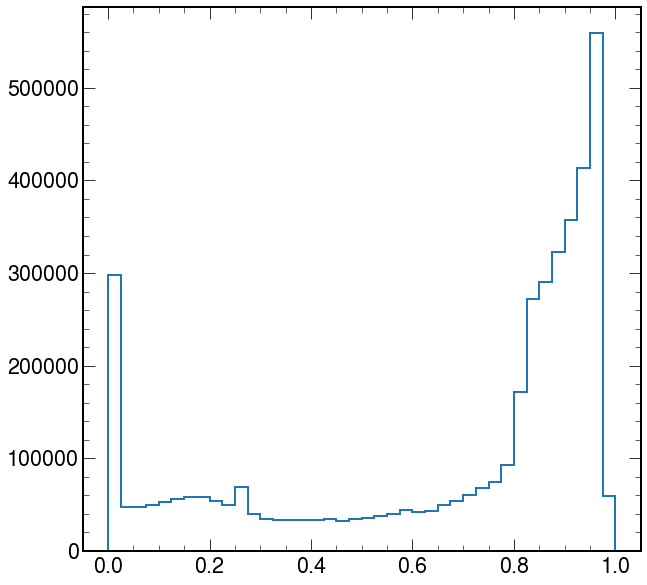

In [6]:
plt.hist(ak.flatten(df_track.id_probabilities[:,:,0]+df_track.id_probabilities[:,:,1]), bins=40, range=(0,1), linewidth=2, histtype='step' )
#plt.legend()

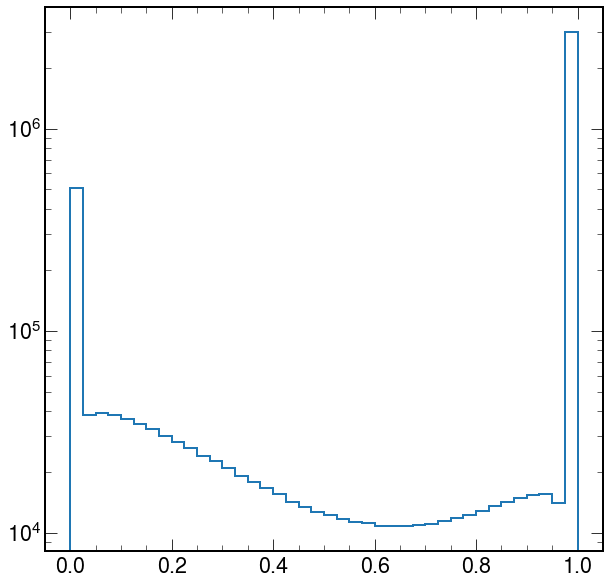

In [7]:
plt.hist(ak.flatten(df_track.raw_em_energy / df_track.raw_energy), bins=40, range=(0,1), linewidth=2, histtype='step' )
plt.yscale("log")
#plt.legend()

In [8]:
ak.num(df_track.trackster_barycenter_eta[EM_mask])

<Array [1482, 1649, 1925, ... 1285, 1858, 2144] type='1930 * int64'>

In [9]:
ak.num(df_calo.stsCP_trackster_barycenter_eta)

<Array [2, 2, 2, 2, 2, 2, ... 2, 2, 2, 2, 2, 2] type='1930 * int64'>

Text(0, 1, 'phi')

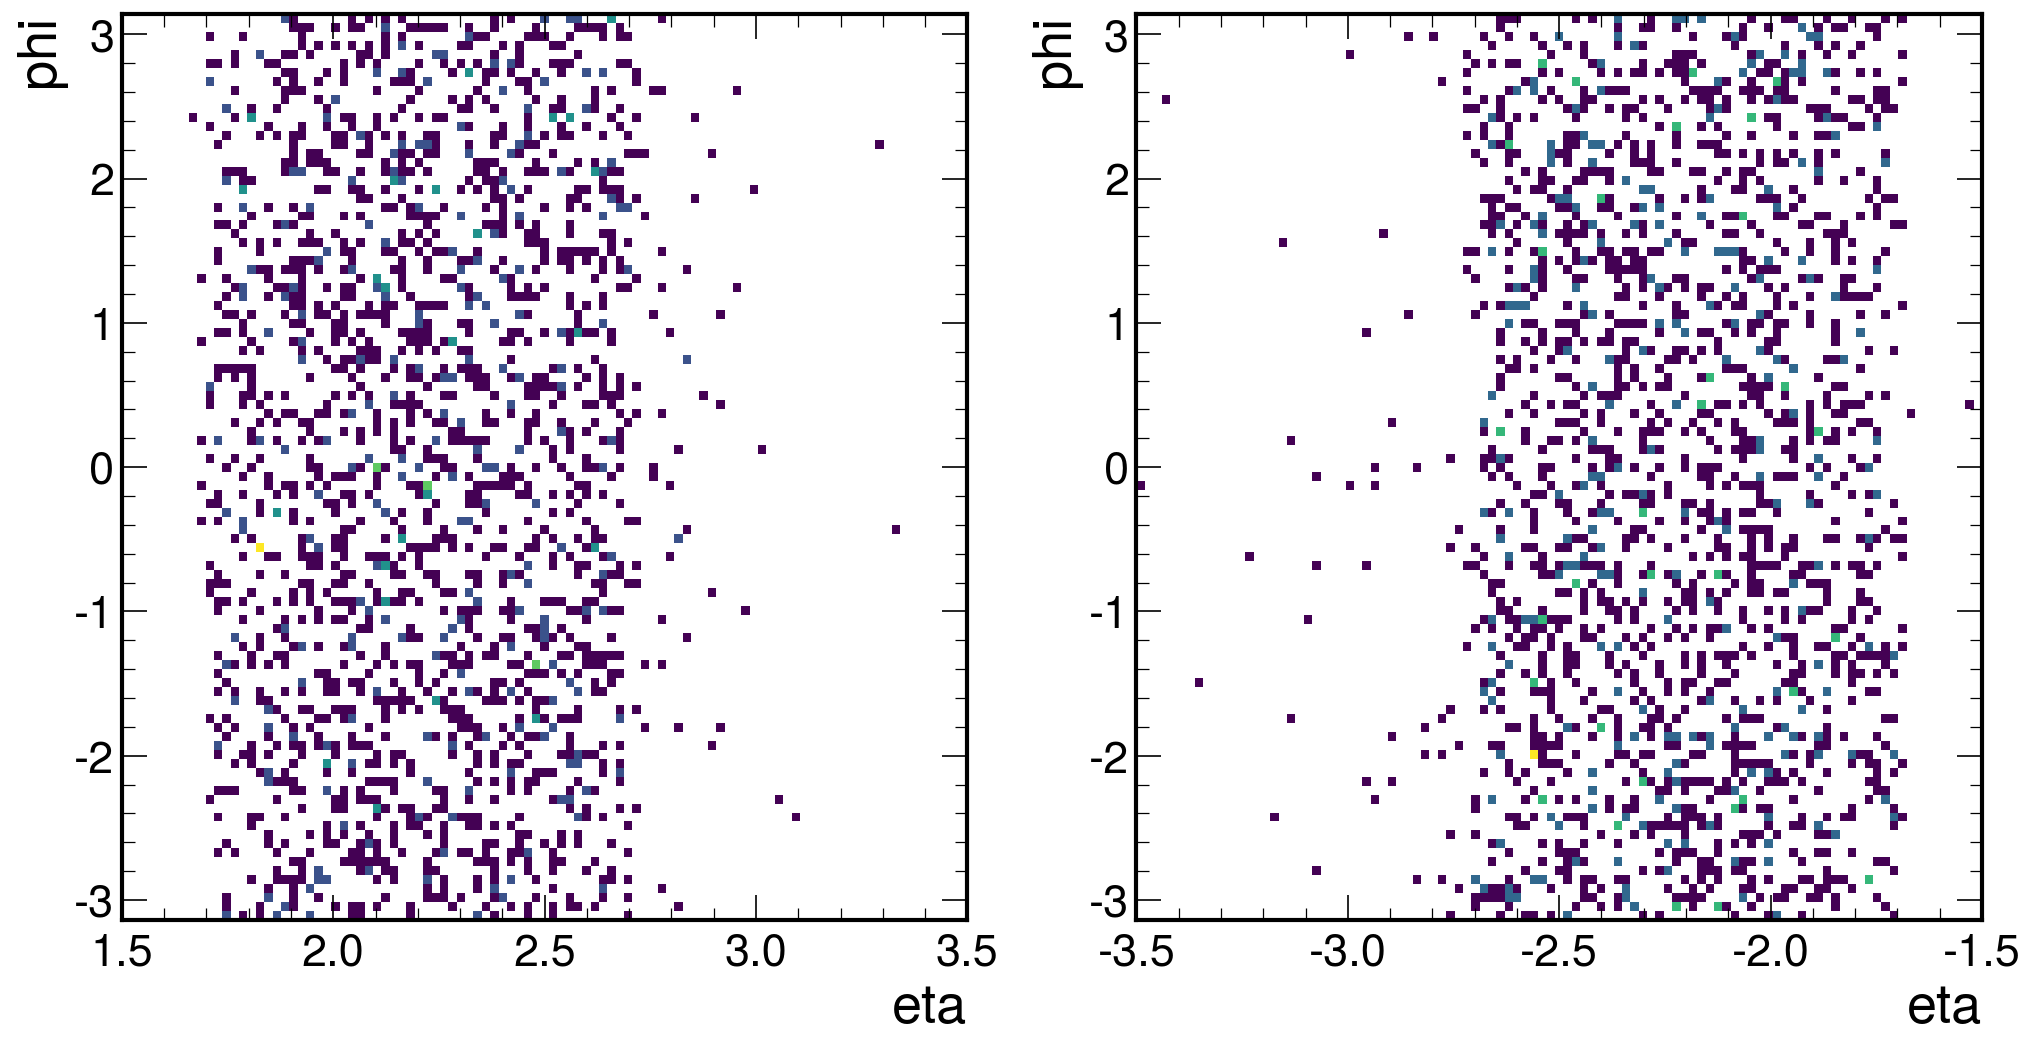

In [10]:
f, ax = plt.subplots(1,2, figsize=(16,8), dpi=150)

zmaskP = df_calo.stsCP_trackster_barycenter_eta > 0 
zmaskM = df_calo.stsCP_trackster_barycenter_eta < 0 

ax[0].hist2d(np.array(ak.flatten(df_calo[zmaskP].stsCP_trackster_barycenter_eta)),
             np.array(ak.flatten(df_calo[zmaskP].stsCP_trackster_barycenter_phi)),
           bins=(101,101), range=((1.5,3.5),(-3.14,3.14)), cmin=1)
ax[0].set_xlabel("eta")
ax[0].set_ylabel("phi")

ax[1].hist2d(np.array(ak.flatten(df_calo[zmaskM].stsCP_trackster_barycenter_eta)),
             np.array(ak.flatten(df_calo[zmaskM].stsCP_trackster_barycenter_phi)),
           bins=(101,101), range=((-3.5,-1.5),(-3.14,3.14)), cmin=1)
ax[1].set_xlabel("eta")
ax[1].set_ylabel("phi")


In [49]:
import numba

@numba.njit
def in_window(calo_eta, calo_phi, calo_z, track_eta, track_phi, track_z, builder):
    deta = 0.10
    dphi = 0.25
    for c_eta, c_phi, c_z, t_eta, t_phi, t_z in zip(calo_eta, calo_phi, calo_z, track_eta, track_phi, track_z):
        builder.begin_list()
        for (ceta, cphi, cz, teta,tphi, tz) in zip(c_eta, c_phi, c_z, t_eta, t_phi, t_z):
            #print(cz, tz, ceta, teta, cphi,tphi)
            same_z = np.sign(cz) == np.sign(tz)
            in_eta = abs(ceta- teta) < deta
            in_phi = abs(((cphi - tphi + np.pi) % (2 * np.pi) - np.pi)) < dphi
            builder.append(same_z & in_eta & in_phi)
        builder.end_list()
    return builder

Computing all the pairs

In [50]:
pairs = ak.argcartesian([df_calo.stsCP_trackster_barycenter_eta, df_track_EM.trackster_barycenter_eta], axis=1)
calo_idx, track_idx = ak.unzip(pairs)

In [51]:
df_calo.eta = df_calo.stsCP_trackster_barycenter_eta
df_calo.phi = df_calo.stsCP_trackster_barycenter_phi
df_calo.z = df_calo.stsCP_barycenter_z

df_track.eta = df_track_EM.trackster_barycenter_eta
df_track.phi = df_track_EM.trackster_barycenter_phi
df_track.z = df_track_EM.barycenter_z

In [52]:
all_calo_eta = df_calo.stsCP_trackster_barycenter_eta[calo_idx]
all_calo_phi = df_calo.stsCP_trackster_barycenter_phi[calo_idx]
all_calo_z = df_calo.stsCP_barycenter_z[calo_idx]

all_track_eta = df_track_EM.trackster_barycenter_eta[track_idx]
all_track_phi = df_track_EM.trackster_barycenter_phi[track_idx]
all_track_z = df_track_EM.barycenter_z[track_idx]

In [286]:
%%timeit
out = in_window(all_calo_eta, all_calo_phi, all_calo_z, all_track_eta, all_track_phi,  all_track_z, ak.ArrayBuilder())

14.6 ms ± 422 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [287]:
%%timeit
out = in_window_nonumba(all_calo_eta, all_calo_phi, all_calo_z, all_track_eta, all_track_phi,  all_track_z, ak.ArrayBuilder())

9.68 s ± 258 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [53]:
out = in_window(all_calo_eta, all_calo_phi, all_calo_z, 
                all_track_eta, all_track_phi,  all_track_z, ak.ArrayBuilder())

In [54]:
goodpairs = pairs[out]

In [20]:
goodpairs[0:3].tolist()

[[(0, 790),
  (0, 1050),
  (0, 1055),
  (0, 1093),
  (0, 1128),
  (0, 1435),
  (1, 10),
  (1, 41),
  (1, 247),
  (1, 448),
  (1, 687)],
 [(0, 931),
  (0, 988),
  (0, 989),
  (0, 992),
  (0, 1088),
  (0, 1090),
  (0, 1091),
  (0, 1152),
  (0, 1210),
  (0, 1237),
  (0, 1243),
  (0, 1244),
  (0, 1406),
  (0, 1457),
  (0, 1640),
  (1, 152),
  (1, 188),
  (1, 239),
  (1, 391),
  (1, 448),
  (1, 482),
  (1, 545),
  (1, 603),
  (1, 710),
  (1, 762),
  (1, 763)],
 [(0, 1183),
  (0, 1184),
  (0, 1273),
  (0, 1277),
  (0, 1332),
  (0, 1343),
  (0, 1347),
  (0, 1456),
  (0, 1499),
  (0, 1501),
  (0, 1502),
  (0, 1668),
  (0, 1772),
  (0, 1807),
  (1, 118),
  (1, 119),
  (1, 180),
  (1, 288),
  (1, 289),
  (1, 362),
  (1, 511),
  (1, 512),
  (1, 539),
  (1, 600),
  (1, 823),
  (1, 868),
  (1, 887),
  (1, 931)]]

Now we have the pairs of caloparticle-trackers that are close in a window

In [55]:
calo_idx_inwindow, track_idx_inwindow = ak.unzip(goodpairs)

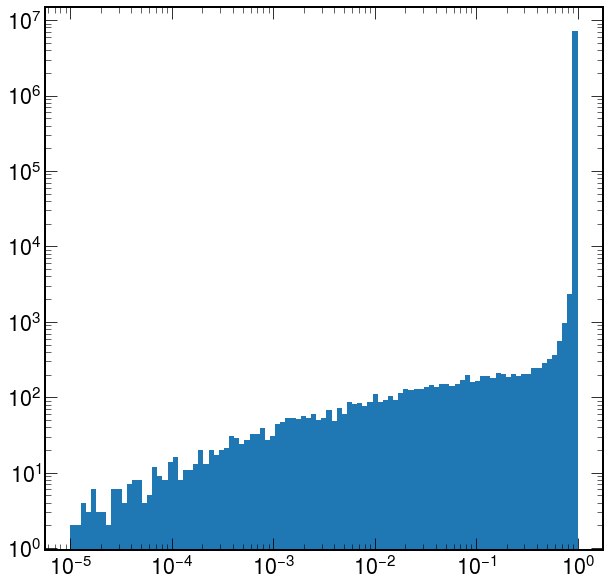

In [56]:
plt.hist(ak.flatten(df_ass.tsCLUE3D_recoToSim_CP_score[EM_mask], axis=None), 
             bins=np.logspace(-5, 0, 100))
plt.yscale('log')
plt.xscale("log")

In [57]:
import numba
@numba.njit
def calo_match_mask(tcks_indices, indices_to_match, builder):
    for tr_ind, index_to_match in zip(tcks_indices, indices_to_match):
        builder.begin_list()
        #Looping other all the calolist for each trackers
        for trInd in range(len(tr_ind)):    
            calo_indices_for_this_track = tr_ind[trInd]
            #print(calo_indices_for_this_track)
            found = False
            for i in range(len(calo_indices_for_this_track)):
                # checking if the index is the one to keep
                #print(index_to_match[trInd])
                if i == index_to_match[trInd]:
                    builder.append(calo_indices_for_this_track[i])
                    found =True
            if not found:
                builder.append(None)
            
        builder.end_list()
    return builder

In [58]:
min_score = 0.3
masked_score  = ak.mask(df_ass.tsCLUE3D_recoToSim_CP_score, df_ass.tsCLUE3D_recoToSim_CP_score<min_score)
armin = ak.fill_none(ak.argmin(masked_score, axis=2), -1)
trackers_to_calo_ = calo_match_mask(df_ass.tsCLUE3D_recoToSim_CP, armin, ak.ArrayBuilder()).snapshot()
# remember to apply the EM_Mask
trackers_to_calo = trackers_to_calo_[EM_mask]

Text(1, 0, 'Total number of trackers matched to a calo in the event')

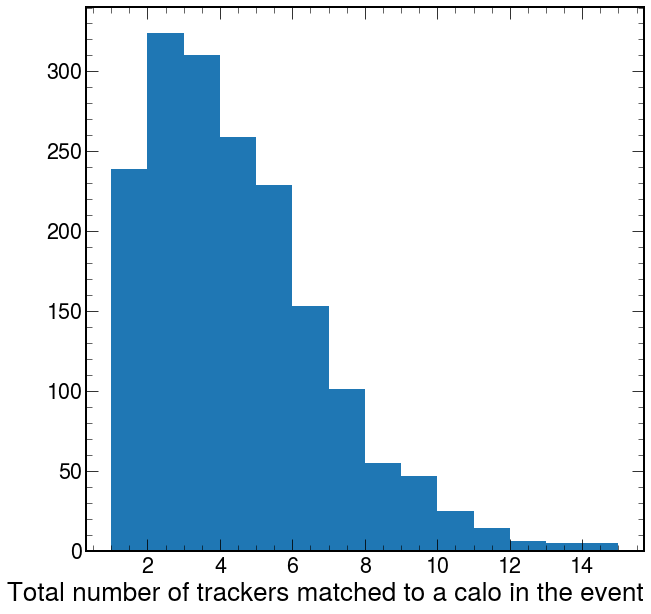

In [59]:
# Trackster matched to caloparticle
num_matched_calo = ak.sum(~ak.is_none(trackers_to_calo, axis=1), axis=1)
plt.hist(num_matched_calo, bins=14, range=(1,15))
plt.xlabel("Total number of trackers matched to a calo in the event")

Now we have the caloindex of each tracker in `trackers_to_calo` and the trackers close to each calo in the `calo_idx_inwindow` and `track_idx_inwindow` arrays

In [33]:
trackers_to_calo[0:3].tolist()

[[None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  1,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  N

In [34]:
goodpairs[0:3].tolist()

[[(0, 790),
  (0, 1050),
  (0, 1055),
  (0, 1093),
  (0, 1128),
  (0, 1435),
  (1, 10),
  (1, 41),
  (1, 247),
  (1, 448),
  (1, 687)],
 [(0, 931),
  (0, 988),
  (0, 989),
  (0, 992),
  (0, 1088),
  (0, 1090),
  (0, 1091),
  (0, 1152),
  (0, 1210),
  (0, 1237),
  (0, 1243),
  (0, 1244),
  (0, 1406),
  (0, 1457),
  (0, 1640),
  (1, 152),
  (1, 188),
  (1, 239),
  (1, 391),
  (1, 448),
  (1, 482),
  (1, 545),
  (1, 603),
  (1, 710),
  (1, 762),
  (1, 763)],
 [(0, 1183),
  (0, 1184),
  (0, 1273),
  (0, 1277),
  (0, 1332),
  (0, 1343),
  (0, 1347),
  (0, 1456),
  (0, 1499),
  (0, 1501),
  (0, 1502),
  (0, 1668),
  (0, 1772),
  (0, 1807),
  (1, 118),
  (1, 119),
  (1, 180),
  (1, 288),
  (1, 289),
  (1, 362),
  (1, 511),
  (1, 512),
  (1, 539),
  (1, 600),
  (1, 823),
  (1, 868),
  (1, 887),
  (1, 931)]]

We now can get the indices of all the trackers close a calo 0

### Now connecting the tracksters in window and calomatched tracksters

In [35]:
track_idx_inwindow[calo_idx_inwindow == 0][0:5].tolist()

[[790, 1050, 1055, 1093, 1128, 1435],
 [931,
  988,
  989,
  992,
  1088,
  1090,
  1091,
  1152,
  1210,
  1237,
  1243,
  1244,
  1406,
  1457,
  1640],
 [1183,
  1184,
  1273,
  1277,
  1332,
  1343,
  1347,
  1456,
  1499,
  1501,
  1502,
  1668,
  1772,
  1807],
 [23,
  79,
  80,
  81,
  148,
  259,
  260,
  278,
  279,
  280,
  365,
  366,
  379,
  497,
  535,
  567,
  591,
  751,
  844,
  848,
  877,
  903,
  918],
 [21, 24, 75, 141, 147, 148, 151, 316, 517, 532, 552, 658]]

Text(1, 0, 'Total trackster in window')

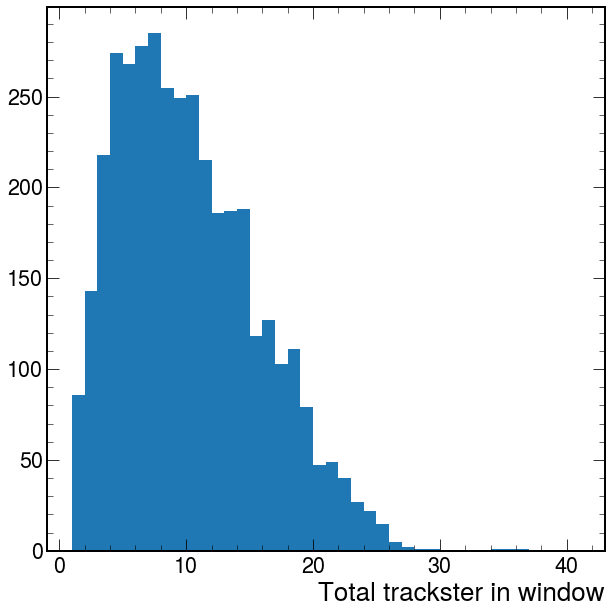

In [79]:
tot_track_in_window = ak.concatenate([ak.num(track_idx_inwindow[calo_idx_inwindow == 0], axis=1), 
                                      ak.num(track_idx_inwindow[calo_idx_inwindow == 1], axis=1)]) 
plt.hist(tot_track_in_window, bins=40, range=(1,41))
plt.xlabel("Total trackster in window")

In [61]:
track_idx_inwindow[calo_idx_inwindow == 1][0:5].tolist()

[[10, 41, 247, 448, 687],
 [152, 188, 239, 391, 448, 482, 545, 710, 762, 763],
 [180, 289, 511, 512, 539, 600, 823, 887, 931],
 [983,
  1055,
  1138,
  1214,
  1215,
  1304,
  1509,
  1528,
  1563,
  1622,
  1633,
  1670,
  1696,
  1844],
 [1033,
  1134,
  1204,
  1264,
  1300,
  1328,
  1330,
  1373,
  1405,
  1460,
  1485,
  1585,
  1624,
  1652,
  1655,
  1656,
  1677]]

Or get the **true** caloparticle matched to each trackers that is in the windo of caloparticle 0

In [62]:
caloid = 1

In [63]:
track_idx_inwindow[calo_idx_inwindow == caloid]

<Array [[10, 41, 247, ... 1888, 1935, 2023]] type='1930 * var * int64'>

In [64]:
trackers_to_calo[  track_idx_inwindow[calo_idx_inwindow == caloid]]

<Array [[1, None, None, ... None, None, None]] type='1930 * var * ?int64'>

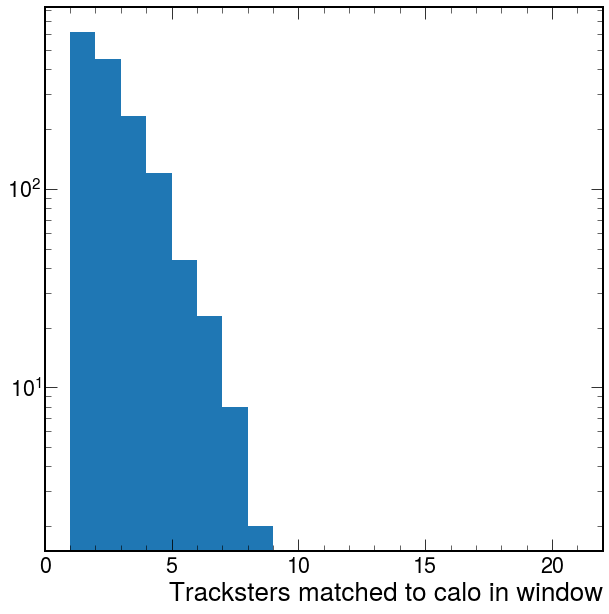

In [65]:
true_in_window = (trackers_to_calo[  track_idx_inwindow[calo_idx_inwindow == caloid]]==caloid)
plt.hist(ak.sum(true_in_window, axis=1), bins=20, range=(1,21))
plt.xlabel("Tracksters matched to calo in window")
plt.yscale("log")

In [66]:
true_in_window[0:3].tolist()

[[True, None, None, None, True],
 [None, True, None, None, None, None, True, None, None, None],
 [None, True, None, None, None, None, None, None, None]]

### Extracting info

In [67]:
norm_PCAVect = (df_track_EM.eVector0_x **2 + df_track_EM.eVector0_y**2  + df_track_EM.eVector0_z**2)**0.5
norm_baryVect = (df_track_EM.barycenter_x **2 + df_track_EM.barycenter_y**2  + df_track_EM.barycenter_z**2)**0.5

In [68]:
prod_scalar = (df_track_EM.barycenter_x * df_track_EM.eVector0_x + df_track_EM.barycenter_y * df_track_EM.eVector0_y + \
                        df_track_EM.barycenter_z * df_track_EM.eVector0_z) /(norm_PCAVect*norm_baryVect)

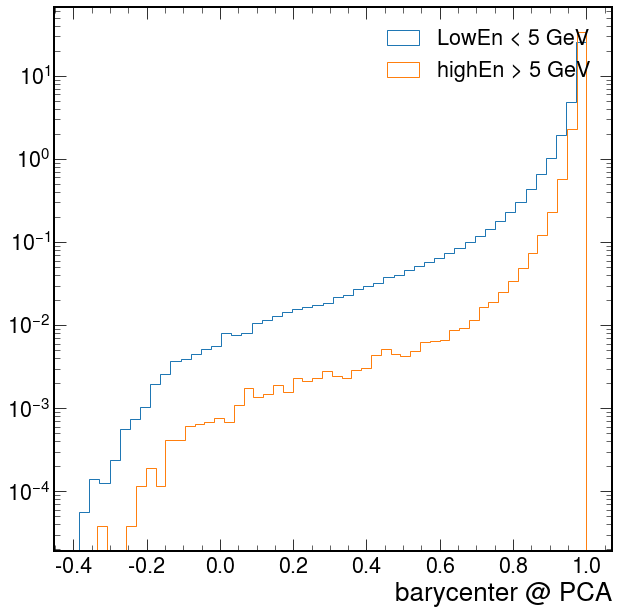

In [69]:
plt.hist(ak.flatten(prod_scalar[df_track_EM.raw_energy< 5] ), bins=50, density=True, histtype="step", label="LowEn < 5 GeV")
plt.hist(ak.flatten(prod_scalar[df_track_EM.raw_energy> 5] ), bins=50, density=True, histtype="step", label="highEn > 5 GeV")
plt.legend()
plt.xlabel("barycenter @ PCA")
plt.yscale("log")

## Write datasets

In [29]:
@numba.njit
def get_truth_matrix(Y, b, pad):
    for yvec in Y:
        b.begin_list()
        for i in range(len(yvec)):
            b.begin_list()
            for j in range(len(yvec)):
                if yvec[i] and yvec[j]:
                    b.append(1.)
                else:
                    b.append(0.)
            b.end_list()
        b.end_list()
    return b
                    

In [95]:
@numba.njit
def get_truth_matrix_padded(Y, N, pad):
    Z = np.zeros((N, pad, pad))
    ev = 0
    for yvec in Y:
        for i in range(len(yvec)):
            for j in range(len(yvec)):
                if i==j:
                    Z[ev, i, j] = 0.
                else:
                    if yvec[i] and yvec[j]:
                        Z[ev, i,j] = 1.
                    else:
                        Z[ev, i,j] = 0
        ev+=1
    return Z
                    

In [70]:
X = [ ]
Y = [ ] 
Y_meta = [ ]

mask_events = ak.num(df_calo.stsCP_raw_energy, axis=1) == 2
padding = 30

for calo_idx in [0, 1]:
    #mask everything
    calo_idx_inwindow_M = calo_idx_inwindow[mask_events]
    track_idx_inwindow_M = track_idx_inwindow[mask_events]
    df_track_EM_M = df_track_EM[mask_events]
    trackers_to_calo_M = trackers_to_calo[mask_events]
    # Get the tracksters in the window of each calo particles
    tracks_in_window = track_idx_inwindow_M[calo_idx_inwindow_M == calo_idx]
    # Get only those trackers by ID
    trk_data = df_track_EM_M[tracks_in_window]
    # Save the input variables
    x = ak.zip({"raw_en": trk_data.raw_energy, 
                     "barycenter_x": trk_data.barycenter_x,
                     "barycenter_y": trk_data.barycenter_y,
                     "barycenter_z": trk_data.barycenter_z,
                     "EV1": trk_data.EV1,
                     "EV2": trk_data.EV2,
                     "EV3": trk_data.EV3,
                     "sigmaPCA1": trk_data.sigmaPCA1,
                     "sigmaPCA2": trk_data.sigmaPCA2,
                     "sigmaPCA3": trk_data.sigmaPCA3,
                     "misalign":  prod_scalar[mask_events][tracks_in_window],
                    }  )
    
    trackers_in_window_truth = ak.fill_none(trackers_to_calo_M[ tracks_in_window ] == calo_idx, False)
    
    # Saving also the caloparticle metadata
    m = df_calo[mask_events,calo_idx]
    X.append(x)
    Y.append(trackers_in_window_truth)
    Y_meta.append(m)

dataset = ak.zip({"X": ak.concatenate(X, axis=0), 
                  "Y": ak.concatenate(Y, axis=0), 
                  "meta": ak.concatenate(Y_meta, axis=0)})
ak.to_parquet(dataset, "dataset.parquet")

In [71]:
dataset.Y[1].tolist()

[False, False, False, True, False, True, True, False, True]

Text(1, 0, 'N trackers in window')

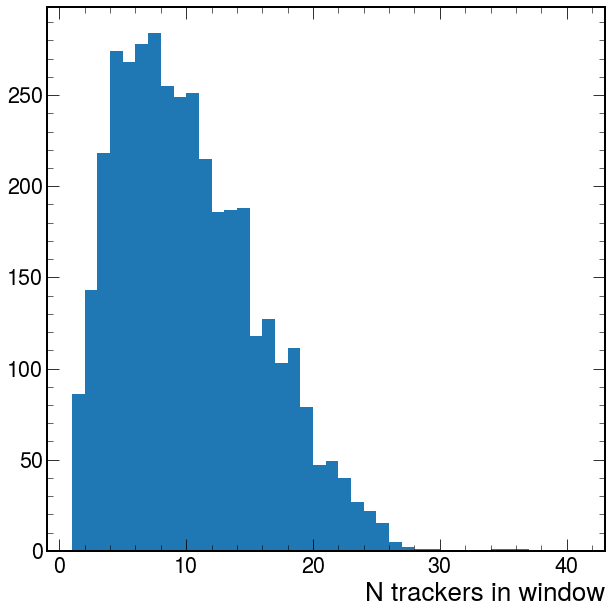

In [83]:
plt.hist(ak.num(dataset.X, axis=1), bins=40, range=(1,41))
plt.xlabel("N trackers in window")
#plt.yscale("log")